In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict


In [2]:
# Crew was doing this for us, by the way.
load_dotenv(override=True)


True

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. Paris, the capital city of France, is often referred to as the “City of Light” (La Ville Lumière) due to its role as a center of enlightenment ... The capital of France has been Paris since its liberation in 1944. Paris is the city of romance par excellence, th

In [4]:
from langchain_core.tools import Tool

tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
    )

In [5]:
tool_search.invoke("What is the capital of France?")

c:\Swapnil\Code\GenAI\eddoner\LearningLLMCode\.venv\Lib\site-packages\pydantic\v1\main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most ... It is home to iconic landmarks like the Eiffel Tower, Notre-Dame Cathedral, and the Louvre Museum, which houses the famous Mona Lisa. Known for ... Paris, the capital of France, is located in the north- central part of the country along the Seine River. Known as "The City of Light," Paris is ... Paris is the city of romance par excellence, the fashion capital and the best example of 

In [6]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [7]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

tool_push.invoke("Hello, me")

In [8]:
tools = [tool_search, tool_push]

In [9]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [10]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [11]:
# This is different:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [12]:
# Step 3: Create a Node


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [13]:
# Step 4: Create Edges


graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

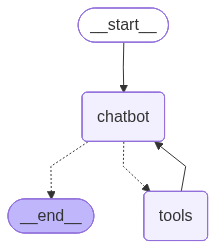

In [14]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [16]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

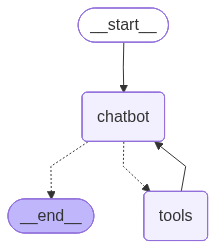

In [17]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='25df403c-fd15-418f-b90b-bfedbfb474cb')]}
{'messages': [HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='25df403c-fd15-418f-b90b-bfedbfb474cb'), AIMessage(content="I'm sorry, but I don't have access to personal information about users unless it has been shared in the conversation. Could you please tell me your name?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 93, 'total_tokens': 124, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CexfIlvsE3osn0iJQ9slmfwY4uk2C', 'service_tier': 'default', 'finish_rea

In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

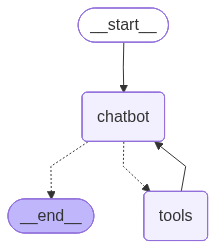

In [20]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='869d566c-cac7-4646-91d4-0a4bcc16b974')]}
{'messages': [HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='869d566c-cac7-4646-91d4-0a4bcc16b974'), AIMessage(content="I don't have access to your personal information, so I can't tell what your name is. If you'd like to share your name or if there's something else you'd like to discuss, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 93, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CexggJxkfDJoHzlCQppPmxmCqTER

In [22]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='869d566c-cac7-4646-91d4-0a4bcc16b974'), AIMessage(content="I don't have access to your personal information, so I can't tell what your name is. If you'd like to share your name or if there's something else you'd like to discuss, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 93, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CexggJxkfDJoHzlCQppPmxmCqTERf', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--a0446b5a-c6cb-4afd-bfcf-ca16eca8e586

In [23]:
# Most recent first

list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='869d566c-cac7-4646-91d4-0a4bcc16b974'), AIMessage(content="I don't have access to your personal information, so I can't tell what your name is. If you'd like to share your name or if there's something else you'd like to discuss, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 93, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CexggJxkfDJoHzlCQppPmxmCqTERf', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--a0446b5a-c6cb-4afd-bfcf-ca16eca8e58

In [25]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

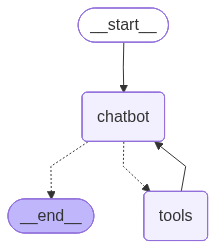

In [26]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [31]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi!! What is my name?', additional_kwargs={}, response_metadata={}, id='f5e9e3e1-56a4-435c-9c03-776aa3edde50'), AIMessage(content="I don't have access to personal data about you unless you've shared it in this conversation. Can you please tell me your name?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 95, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-Cexpo8vnv5GF8baxTsaT0XR1ZSwVG', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--19d645dc-0bf9-4eeb-a9ab-0c994bad520f-0', usage_metadata={'input_tokens': 95, 'output_tokens': 26, 'total_tokens': 121, 'i